In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

In [2]:
lags = [1, 2, 4]
lag_graphs = dict()

for lag in lags:
    lag_G = nx.read_graphml(f'../causal_graphs/lag{lag}_causality_graph.graphml')
    lag_graphs[lag] = lag_G

In [3]:
for lag in lags:
    lag_G = lag_graphs[lag]
    is_conn = nx.is_strongly_connected(lag_G)

    if is_conn:
        print(f'Graph for lag {lag} is strongly connected')
    else:
        print(f'Graph for lag {lag} is not strongly connected')

Graph for lag 1 is strongly connected
Graph for lag 2 is strongly connected
Graph for lag 4 is strongly connected


## Characteristics

In [4]:
for lag in lags:
    lag_G = lag_graphs[lag]
    diam = nx.diameter(lag_G)
    radius = nx.radius(lag_G)
    ave_shortest_p = nx.average_shortest_path_length(lag_G)
    clustering_coefs = nx.cluster.clustering(lag_G)
    gl_clustering_coef = nx.cluster.transitivity(lag_G)

    print(f'Diameter of the graph of lag {lag}: {diam}')
    print(f'Radius of the graph of lag {lag}: {radius}')
    print(f'Average shortest path of the graph of lag {lag}: {ave_shortest_p:.2f}')
    print(f'Average clustering coefficient of the nodes of the graph of lag {lag}: {np.mean(list(clustering_coefs.values())):.2f}')
    print(f'Global clustering coefficient of the graph of lag {lag}: {gl_clustering_coef:.2f}')
    print()

Diameter of the graph of lag 1: 3
Radius of the graph of lag 1: 3
Average shortest path of the graph of lag 1: 1.84
Average clustering coefficient of the nodes of the graph of lag 1: 0.38
Global clustering coefficient of the graph of lag 1: 0.42

Diameter of the graph of lag 2: 3
Radius of the graph of lag 2: 2
Average shortest path of the graph of lag 2: 1.74
Average clustering coefficient of the nodes of the graph of lag 2: 0.40
Global clustering coefficient of the graph of lag 2: 0.39

Diameter of the graph of lag 4: 3
Radius of the graph of lag 4: 2
Average shortest path of the graph of lag 4: 1.73
Average clustering coefficient of the nodes of the graph of lag 4: 0.44
Global clustering coefficient of the graph of lag 4: 0.44



Вывод:  
- Диаметр и средняя длина кратчайшего пути достаточно малы, по сравнению с размерностью графа, для любого значения лага.  
- Это говорит о наличии свойств small world.  
- Активы на рынке достаточно сильно взаимосвязаны, т.е. влияние на какой-либо из них окажет некоторое влияние на весь рынок.

Text(0.5, 0.98, 'Distribution of clustering coefficients')

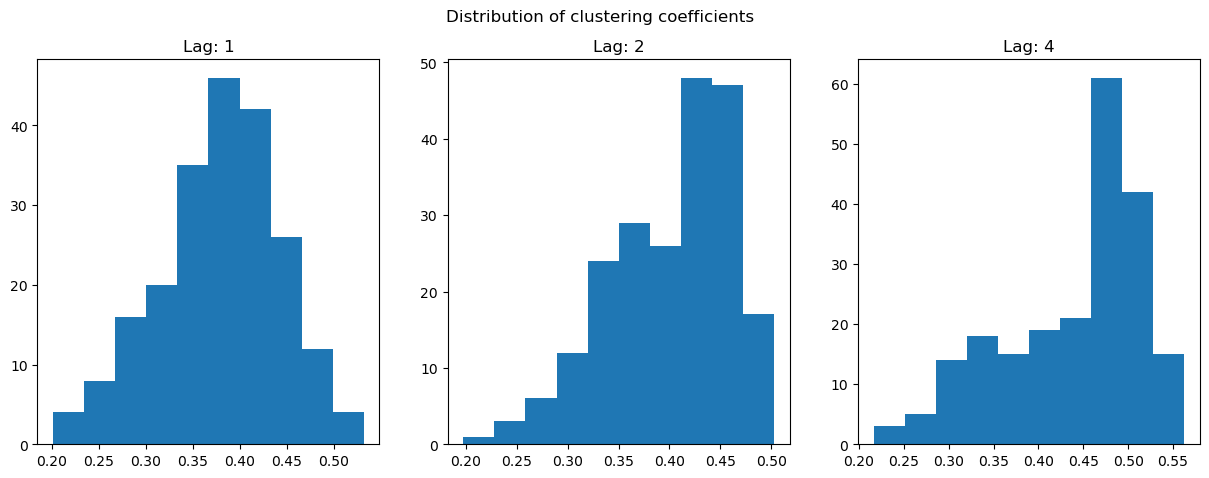

In [5]:
fig, axes = plt.subplots(1, len(lags))

for idx, lag in enumerate(lags):
    lag_G = lag_graphs[lag]
    clustering_coefs = nx.cluster.clustering(lag_G)

    axes[idx].hist(list(clustering_coefs.values()))
    axes[idx].set_title(f'Lag: {lag}')
    
fig.set_size_inches(15, 5)
fig.suptitle("Distribution of clustering coefficients")

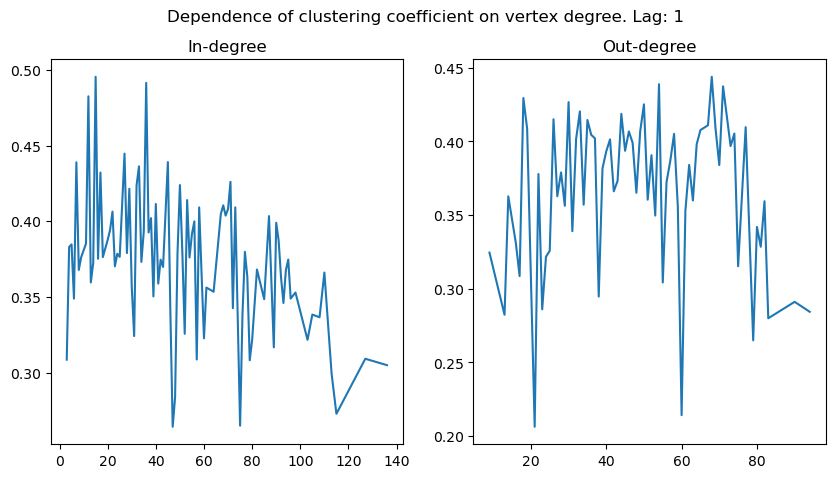

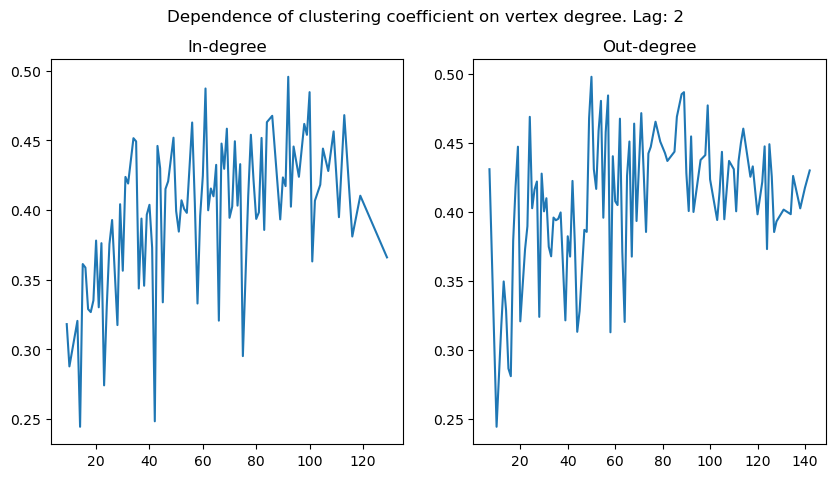

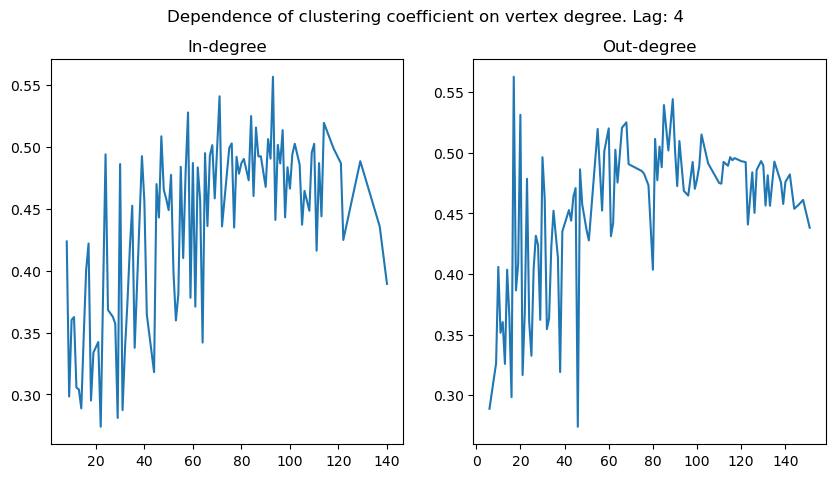

In [6]:
def get_clustering_degree_data(graph, clustering_coefs, degrees):
    degree_clustering = {}
    for node in graph.nodes():
        degree = degrees[node]
        if degree not in degree_clustering:
            degree_clustering[degree] = []
        degree_clustering[degree].append(clustering_coefs[node])

    avg_clustering = {}
    for degree in degree_clustering:
        avg_clustering[degree] = np.mean(degree_clustering[degree])
        
    degrees_sorted = sorted(avg_clustering.keys())
    clustering_avg = [avg_clustering[deg] for deg in degrees_sorted]

    return degrees_sorted, clustering_avg

for lag in lags:
    fig, axes = plt.subplots(1, 2)

    lag_G = lag_graphs[lag]
    clustering_coefs = nx.cluster.clustering(lag_G)
    
    in_degrees_sorted, in_clustering_avg = get_clustering_degree_data(lag_G, clustering_coefs, dict(lag_G.in_degree()))
    out_degrees_sorted, out_clustering_avg = get_clustering_degree_data(lag_G, clustering_coefs, dict(lag_G.out_degree()))

    axes[0].plot(in_degrees_sorted, in_clustering_avg)
    axes[1].plot(out_degrees_sorted, out_clustering_avg)
    axes[0].set_title('In-degree')
    axes[1].set_title('Out-degree')
    fig.set_size_inches(10, 5)
    fig.suptitle(f"Dependence of clustering coefficient on vertex degree. Lag: {lag}")

Вывод:  
- Граф обладает некоторой кластерной структурой
- С ростом лага структура проявляется сильнее. Это может говорить о "замедленном" влиянии активов друг на друга. (кажется, это должно быть характерно для фондового рынка)
- Коэф. кластеризации слабо зависит от степени вершин. Это может говорить о том, что граф не является scale free network

In [7]:
def get_shortest_path_degree_data(graph, degrees):
    nodes_ave_shortest_path = {}

    for node, spaths in nx.shortest_path_length(graph):
        spaths.pop(node)
        nodes_ave_shortest_path[node] = np.mean(list(spaths.values()))

    degree_sp = {}
    for node in graph.nodes():
        degree = degrees[node]
        if degree not in degree_sp:
            degree_sp[degree] = []
        degree_sp[degree].append(nodes_ave_shortest_path[node])

    avg_sp = {}
    for degree in degree_sp:
        avg_sp[degree] = np.mean(degree_sp[degree])
        
    degrees_sorted = sorted(avg_sp.keys())
    sp_len_avg = [avg_sp[deg] for deg in degrees_sorted]

    return degrees_sorted, sp_len_avg

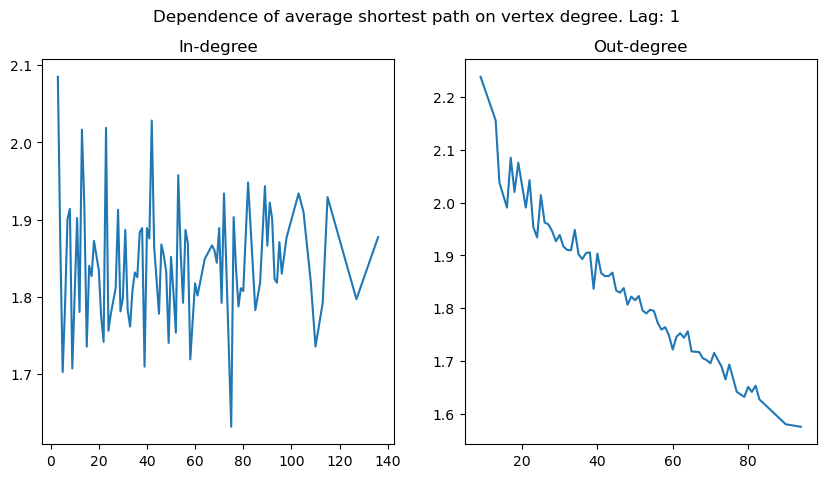

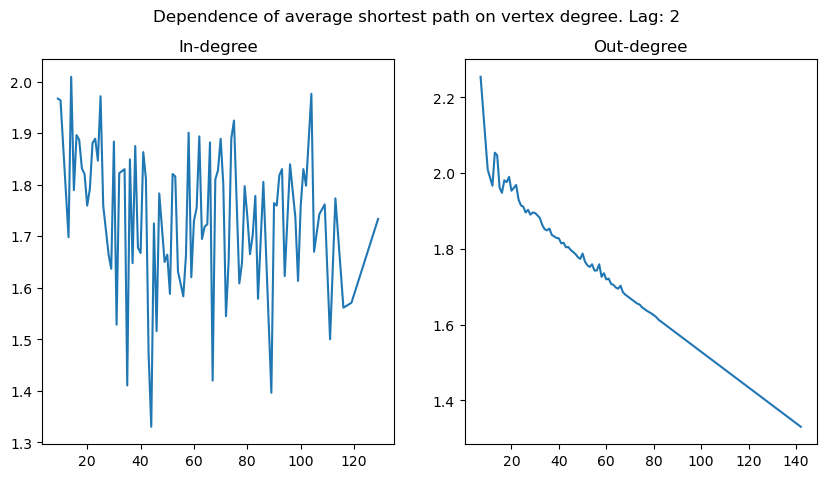

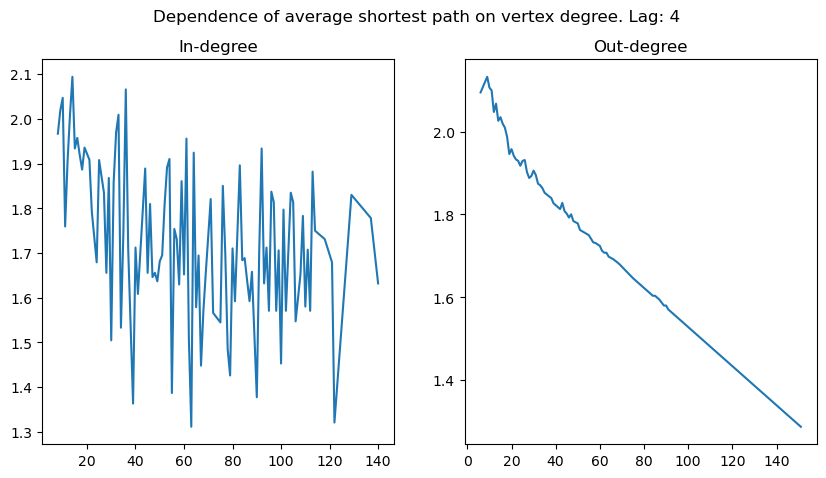

In [8]:
for lag in lags:
    fig, axes = plt.subplots(1, 2)

    lag_G = lag_graphs[lag]
    degrees = dict(lag_G.in_degree())
    
    in_degrees_sorted, in_sp_len_avg = get_shortest_path_degree_data(lag_G, dict(lag_G.in_degree()))
    out_degrees_sorted, out_sp_len_avg = get_shortest_path_degree_data(lag_G, dict(lag_G.out_degree()))

    axes[0].plot(in_degrees_sorted, in_sp_len_avg)
    axes[1].plot(out_degrees_sorted, out_sp_len_avg)
    axes[0].set_title('In-degree')
    axes[1].set_title('Out-degree')
    fig.set_size_inches(10, 5)
    fig.suptitle(f"Dependence of average shortest path on vertex degree. Lag: {lag}")

- Cредняя длина кратчайшего пути зависит от out-degree вершины в виде Power Law
- Подтверждает наличие хабов в сети, что может указывать на small world

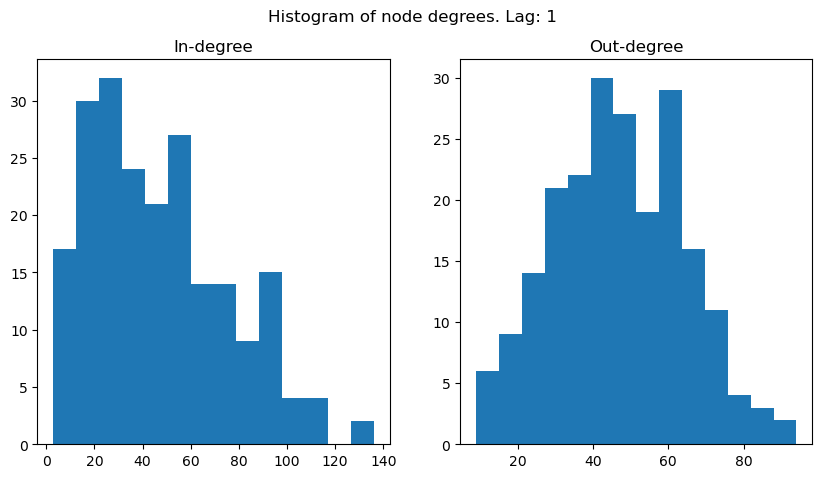

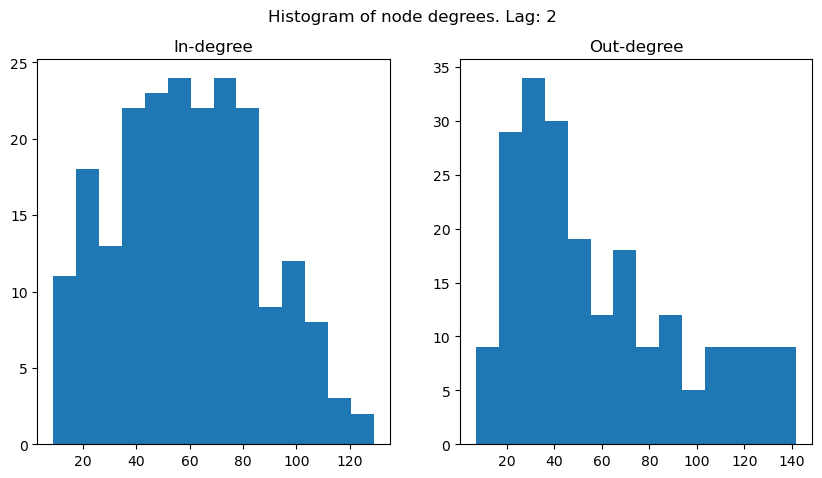

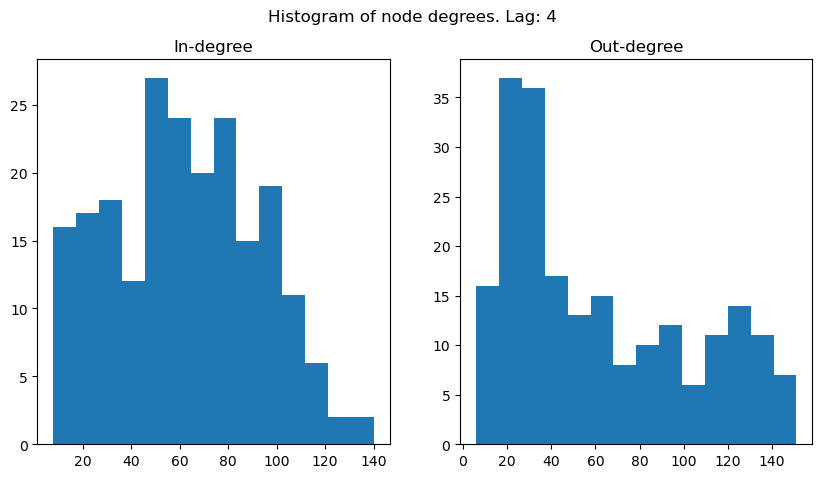

In [9]:
for lag in lags:
    fig, axes = plt.subplots(1, 2)

    lag_G = lag_graphs[lag]
    in_degrees = dict(lag_G.in_degree())
    out_degrees = dict(lag_G.out_degree())


    axes[0].hist(list(in_degrees.values()), bins=int(np.sqrt(len(in_degrees.values()))))
    axes[1].hist(list(out_degrees.values()), bins=int(np.sqrt(len(out_degrees.values()))))
    axes[0].set_title('In-degree')
    axes[1].set_title('Out-degree')
    fig.set_size_inches(10, 5)
    fig.suptitle(f"Histogram of node degrees. Lag: {lag}")

- Распределение слабо похоже на Power Law. Сеть не является Scale-free network
- С изменением лага уменьшается средняя out-degree вершин

In [10]:
lag_centralities = dict()

for lag in lags:
    lag_G = lag_graphs[lag]
    nodes_data = list(lag_G.nodes())
    in_degrees = lag_G.in_degree()
    out_degrees = lag_G.out_degree()
    bcs = nx.betweenness_centrality(lag_G)

    ind_data = [in_degrees[node] for node in nodes_data]
    outd_data = [out_degrees[node] for node in nodes_data]
    bcs_data = [bcs[node] for node in nodes_data]

    df = {'nodes': nodes_data, 'in_degree': ind_data, 'out_degree': outd_data, 'betweenness_centrality': bcs_data}
    lag_centralities[lag] = pl.DataFrame(df)

### Наименьшие in-degree

In [11]:
for lag in lags:
    print('Lag:', lag)
    print(lag_centralities[lag].select('nodes', 'in_degree').sort('in_degree').head(5))

Lag: 1
shape: (5, 2)
┌───────┬───────────┐
│ nodes ┆ in_degree │
│ ---   ┆ ---       │
│ str   ┆ i64       │
╞═══════╪═══════════╡
│ LIFE  ┆ 3         │
│ BELU  ┆ 4         │
│ PLZL  ┆ 5         │
│ TGKB  ┆ 6         │
│ TRNFP ┆ 6         │
└───────┴───────────┘
Lag: 2
shape: (5, 2)
┌───────┬───────────┐
│ nodes ┆ in_degree │
│ ---   ┆ ---       │
│ str   ┆ i64       │
╞═══════╪═══════════╡
│ VSYD  ┆ 9         │
│ EELT  ┆ 10        │
│ OZON  ┆ 10        │
│ TASBP ┆ 10        │
│ PLZL  ┆ 13        │
└───────┴───────────┘
Lag: 4
shape: (5, 2)
┌───────┬───────────┐
│ nodes ┆ in_degree │
│ ---   ┆ ---       │
│ str   ┆ i64       │
╞═══════╪═══════════╡
│ LIFE  ┆ 8         │
│ VSYD  ┆ 8         │
│ OZON  ┆ 9         │
│ SMLT  ┆ 10        │
│ PLZL  ┆ 11        │
└───────┴───────────┘


### Наибольшие in-degree

In [12]:
for lag in lags:
    print('Lag:', lag)
    print(lag_centralities[lag].select('nodes', 'in_degree').sort('in_degree').tail(5))

Lag: 1
shape: (5, 2)
┌───────┬───────────┐
│ nodes ┆ in_degree │
│ ---   ┆ ---       │
│ str   ┆ i64       │
╞═══════╪═══════════╡
│ GAZA  ┆ 110       │
│ YRSB  ┆ 113       │
│ ETLN  ┆ 115       │
│ YRSBP ┆ 127       │
│ ROST  ┆ 136       │
└───────┴───────────┘
Lag: 2
shape: (5, 2)
┌───────┬───────────┐
│ nodes ┆ in_degree │
│ ---   ┆ ---       │
│ str   ┆ i64       │
╞═══════╪═══════════╡
│ KAZTP ┆ 113       │
│ LSNG  ┆ 116       │
│ MRKC  ┆ 119       │
│ ETLN  ┆ 129       │
│ GAZA  ┆ 129       │
└───────┴───────────┘
Lag: 4
shape: (5, 2)
┌───────┬───────────┐
│ nodes ┆ in_degree │
│ ---   ┆ ---       │
│ str   ┆ i64       │
╞═══════╪═══════════╡
│ KUZB  ┆ 121       │
│ LSNG  ┆ 122       │
│ GAZAP ┆ 129       │
│ GAZA  ┆ 137       │
│ ENPG  ┆ 140       │
└───────┴───────────┘


### Наименьшие out-degree

In [13]:
for lag in lags:
    print('Lag:', lag)
    print(lag_centralities[lag].select('nodes', 'out_degree').sort('out_degree').head(5))

Lag: 1
shape: (5, 2)
┌───────┬────────────┐
│ nodes ┆ out_degree │
│ ---   ┆ ---        │
│ str   ┆ i64        │
╞═══════╪════════════╡
│ KBSB  ┆ 9          │
│ VSYDP ┆ 9          │
│ CNTL  ┆ 13         │
│ LVHK  ┆ 13         │
│ YAKG  ┆ 13         │
└───────┴────────────┘
Lag: 2
shape: (5, 2)
┌───────┬────────────┐
│ nodes ┆ out_degree │
│ ---   ┆ ---        │
│ str   ┆ i64        │
╞═══════╪════════════╡
│ KBSB  ┆ 7          │
│ VSYDP ┆ 10         │
│ VSYD  ┆ 12         │
│ LVHK  ┆ 13         │
│ TNSE  ┆ 13         │
└───────┴────────────┘
Lag: 4
shape: (5, 2)
┌───────┬────────────┐
│ nodes ┆ out_degree │
│ ---   ┆ ---        │
│ str   ┆ i64        │
╞═══════╪════════════╡
│ VSYDP ┆ 6          │
│ NNSB  ┆ 9          │
│ KBSB  ┆ 10         │
│ VSYD  ┆ 10         │
│ TASBP ┆ 11         │
└───────┴────────────┘


### Наибольшие out-degree

In [14]:
for lag in lags:
    print('Lag:', lag)
    print(lag_centralities[lag].select('nodes', 'out_degree').sort('out_degree').tail(5))

Lag: 1
shape: (5, 2)
┌───────┬────────────┐
│ nodes ┆ out_degree │
│ ---   ┆ ---        │
│ str   ┆ i64        │
╞═══════╪════════════╡
│ AGRO  ┆ 82         │
│ SNGS  ┆ 82         │
│ MOEX  ┆ 83         │
│ LSNG  ┆ 90         │
│ MGNT  ┆ 94         │
└───────┴────────────┘
Lag: 2
shape: (5, 2)
┌───────┬────────────┐
│ nodes ┆ out_degree │
│ ---   ┆ ---        │
│ str   ┆ i64        │
╞═══════╪════════════╡
│ HYDR  ┆ 138        │
│ TATN  ┆ 138        │
│ MSNG  ┆ 140        │
│ SNGS  ┆ 142        │
│ VTBR  ┆ 142        │
└───────┴────────────┘
Lag: 4
shape: (5, 2)
┌───────┬────────────┐
│ nodes ┆ out_degree │
│ ---   ┆ ---        │
│ str   ┆ i64        │
╞═══════╪════════════╡
│ SNGS  ┆ 144        │
│ MSNG  ┆ 146        │
│ VTBR  ┆ 148        │
│ LSNGP ┆ 151        │
│ TGKA  ┆ 151        │
└───────┴────────────┘


Betweenness centrality вряд ли является хорошим централити индексом для этой задачи, но всё же:

### Наименьшие BC

In [15]:
for lag in lags:
    print('Lag:', lag)
    print(lag_centralities[lag].select('nodes', 'betweenness_centrality').sort('betweenness_centrality').head(5))

Lag: 1
shape: (5, 2)
┌───────┬────────────────────────┐
│ nodes ┆ betweenness_centrality │
│ ---   ┆ ---                    │
│ str   ┆ f64                    │
╞═══════╪════════════════════════╡
│ VSYDP ┆ 0.000188               │
│ LIFE  ┆ 0.000315               │
│ KRKNP ┆ 0.000439               │
│ TRNFP ┆ 0.000449               │
│ GMKN  ┆ 0.000457               │
└───────┴────────────────────────┘
Lag: 2
shape: (5, 2)
┌───────┬────────────────────────┐
│ nodes ┆ betweenness_centrality │
│ ---   ┆ ---                    │
│ str   ┆ f64                    │
╞═══════╪════════════════════════╡
│ OZON  ┆ 0.000171               │
│ VSYD  ┆ 0.00023                │
│ SAGO  ┆ 0.000457               │
│ TASBP ┆ 0.000493               │
│ ABIO  ┆ 0.000495               │
└───────┴────────────────────────┘
Lag: 4
shape: (5, 2)
┌───────┬────────────────────────┐
│ nodes ┆ betweenness_centrality │
│ ---   ┆ ---                    │
│ str   ┆ f64                    │
╞═══════╪══════════════════

### Наибольшие BC

In [16]:
for lag in lags:
    print('Lag:', lag)
    print(lag_centralities[lag].select('nodes', 'betweenness_centrality').sort('betweenness_centrality').tail(5))

Lag: 1
shape: (5, 2)
┌───────┬────────────────────────┐
│ nodes ┆ betweenness_centrality │
│ ---   ┆ ---                    │
│ str   ┆ f64                    │
╞═══════╪════════════════════════╡
│ YRSB  ┆ 0.019242               │
│ MGNT  ┆ 0.021002               │
│ MDMG  ┆ 0.02185                │
│ APTK  ┆ 0.022554               │
│ FLOT  ┆ 0.026177               │
└───────┴────────────────────────┘
Lag: 2
shape: (5, 2)
┌───────┬────────────────────────┐
│ nodes ┆ betweenness_centrality │
│ ---   ┆ ---                    │
│ str   ┆ f64                    │
╞═══════╪════════════════════════╡
│ MRKP  ┆ 0.009561               │
│ ENPG  ┆ 0.009692               │
│ ETLN  ┆ 0.013391               │
│ LSNGP ┆ 0.013595               │
│ LSNG  ┆ 0.014146               │
└───────┴────────────────────────┘
Lag: 4
shape: (5, 2)
┌───────┬────────────────────────┐
│ nodes ┆ betweenness_centrality │
│ ---   ┆ ---                    │
│ str   ┆ f64                    │
╞═══════╪══════════════════

Ассортативность близка к нулю (как у многих реальных сетей)

In [17]:
for lag in lags:
    lag_G = lag_graphs[lag]
    r = nx.degree_assortativity_coefficient(lag_G)

    print(f'Degree assortativity. Lag: {lag} = {r:.3f}')

Degree assortativity. Lag: 1 = -0.087
Degree assortativity. Lag: 2 = 0.036
Degree assortativity. Lag: 4 = 0.061


Общие выводы:
- Сеть фондового рынка - Small World
- Она не является Scale Free
- Сеть сильно связана друг с другом. Влияние на некоторое подмножество активов окажет влияние на всю сеть
- Ноды оказывающие влияние на всю сеть: VTBR, TATN, etc
- С увеличением лага сеть принимает всё более сильную кластерную структуру

In [18]:
def stock_rw(graph, start_node, n_steps=100):
    current = start_node
    visit_count = {v: 0 for v in graph.nodes()}

    for step in range(n_steps):
        visit_count[current] += 1

        proba = dict()
        for u, v, data in graph.edges(current, data=True):
            proba[v] = data['weight']

        norm_value = np.sum(list(proba.values()))
        for v in proba:
            proba[v] /= norm_value

        next_node = np.random.choice(list(proba.keys()), p=list(proba.values())).item()
        current = next_node

    for v in visit_count:
        visit_count[v] /= n_steps
        
    return visit_count

In [19]:
visit_count = stock_rw(lag_graphs[1], 'TATN')

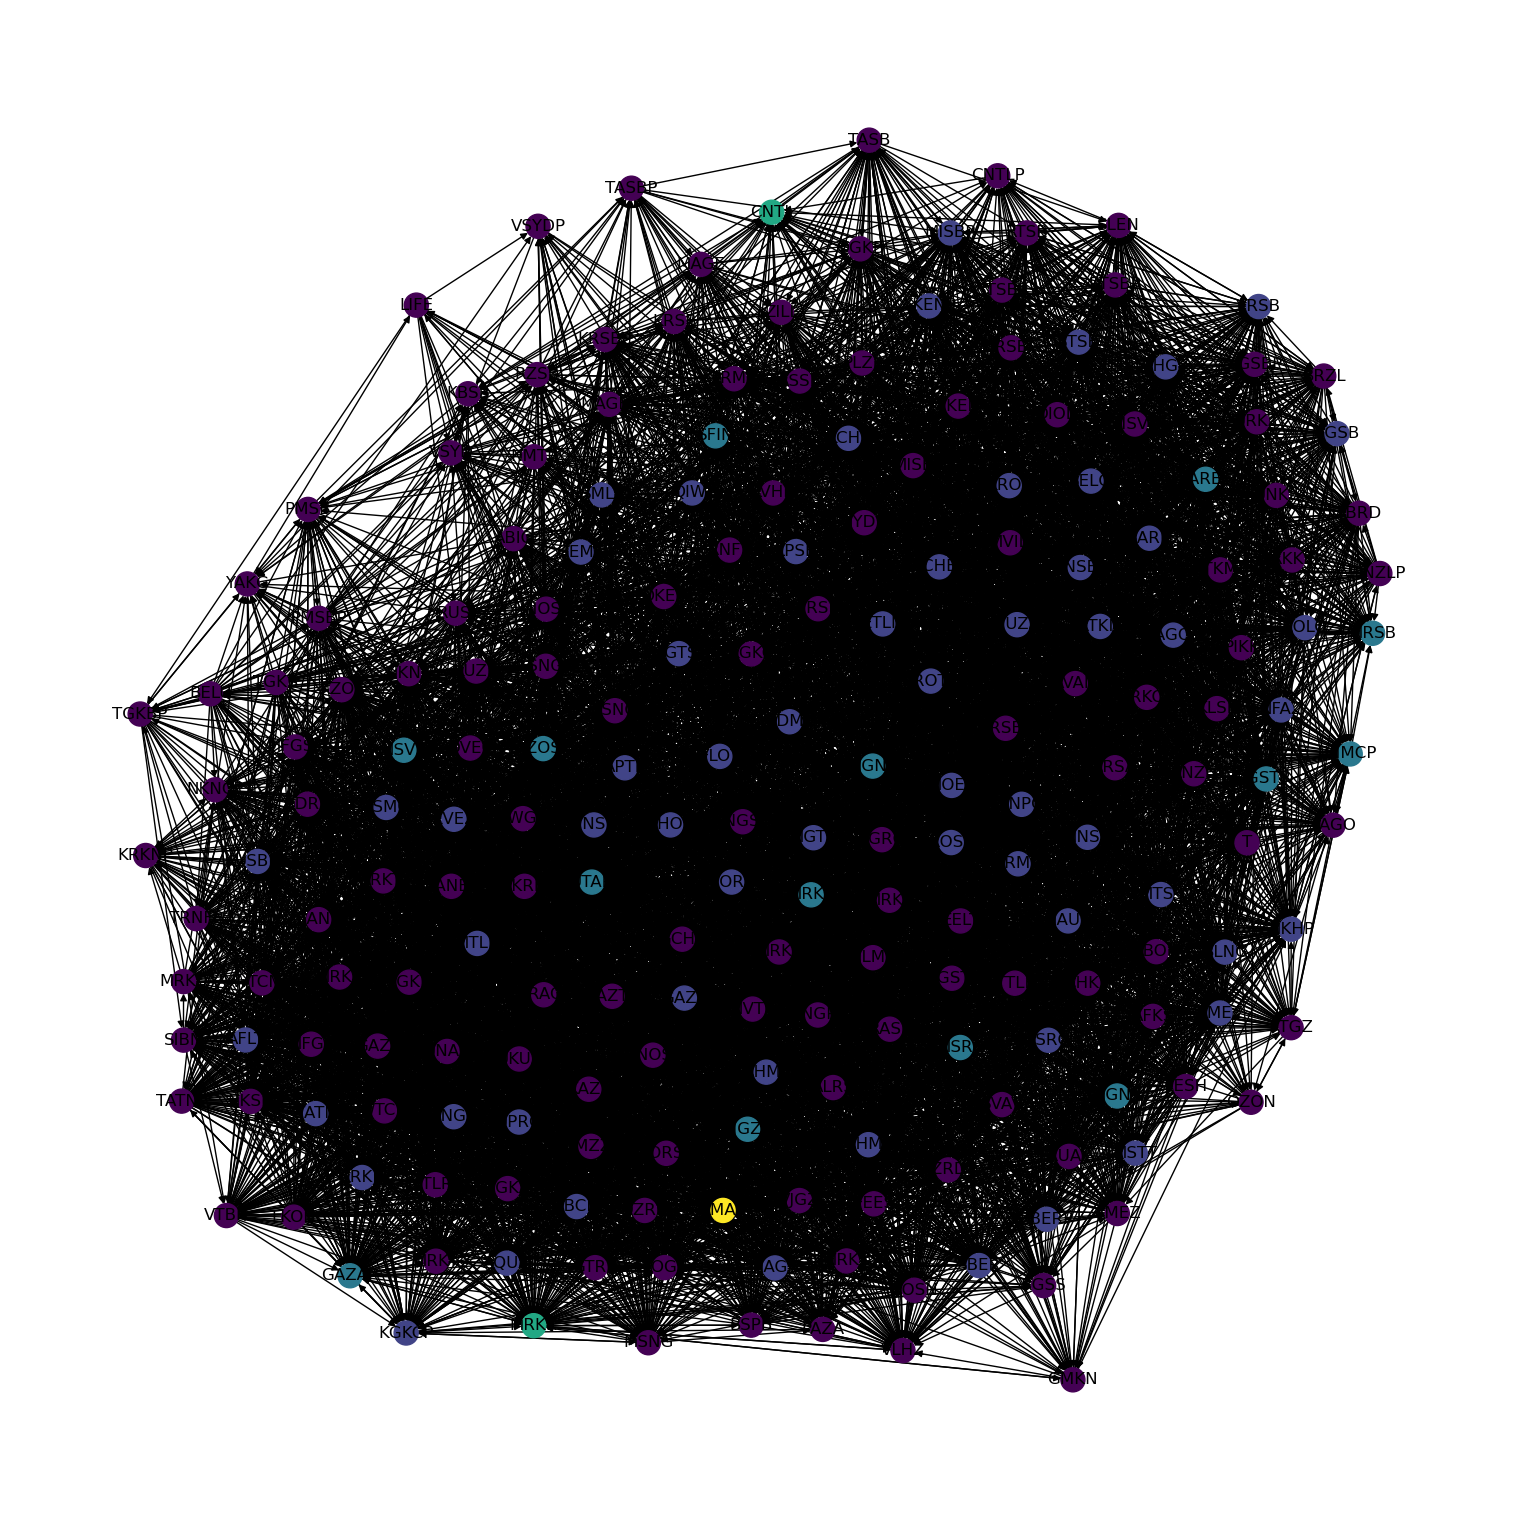

In [20]:
colors = [visit_count[v] for v in lag_graphs[1].nodes()]

pos = nx.nx_pydot.graphviz_layout(lag_graphs[1], 'fdp')
nx.draw(lag_graphs[1], pos, with_labels=True, node_color=colors, alpha=1)
plt.gcf().set_size_inches(15, 15)